In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer



#sys.path.append("../../src")  # adjust path as needed
#from data_loader import LoadData
from ml_model import MlModels

In [86]:
#instiantiate the reading class
merged_df = pd.read_csv('../../../../Data_sets/Quick_Start/Data/merged_all.csv')

print(merged_df.columns)
"""
input_path = path
output_path = path + 'fomatted_data/Updated/with_clinical_data'
data = LoadData.merged_data(data_path=input_path, output_path=output_path, gene_list=selected_genes.to_list(), 
                write_csv=1, phaseIandII=1, genetic_cohort=1,clinical_data=1)

genedata_all,unmatchedkeys = data.gene_expression(match_event=False)
"""

print("Any NaN values in merged_df", merged_df.isnull().values.any())

Index(['PATNO', 'MRIRSLT', 'lh_MeanThickness', 'rh_MeanThickness',
       'lh_WhiteSurfArea', 'rh_WhiteSurfArea', 'rhCerebralWhiteMatterVol',
       'lhCerebralWhiteMatterVol', 'Left_Cerebellum_White_Matter',
       'Right_Cerebellum_White_Matter',
       ...
       'ENSG00000261740', 'ENSG00000204577', 'ENSG00000213221',
       'ENSG00000166136', 'ENSG00000165983', 'ENSG00000254929',
       'ENSG00000135929', 'NHY_BL', 'EVENT_ID', 'NHY'],
      dtype='object', length=119)
Any NaN values in merged_df True


In [87]:
nhy_map = {0:0,1:1,2:1,3:1,4:1,5:1}

merged_df['GENDER'] = merged_df['GENDER'].map({'Male': 0, 'Female': 1})
merged_df.loc[:,"NHY_MAPPED"] = merged_df["NHY"].map(nhy_map)
target_col = "NHY_MAPPED"

In [88]:
merged_df = merged_df.dropna()


In [89]:
X = merged_df.drop(columns=['NHY','NHY_BL', 'PATNO', 'EVENT_ID']) 
y = merged_df[target_col]

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

knn = KNeighborsClassifier()

cv_folds = round(1 / 0.15)
cv_scores = cross_val_score(knn, X_train, y_train, cv=cv_folds)

print(f"Cross-validation scores ({cv_folds} folds):", cv_scores)
print("Mean CV score:", cv_scores.mean())

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

Cross-validation scores (7 folds): [0.54794521 0.46575342 0.49315068 0.56164384 0.49315068 0.5890411
 0.42465753]
Mean CV score: 0.5107632093933464
              precision    recall  f1-score   support

           0       0.46      0.45      0.46        55
           1       0.59      0.60      0.60        73

    accuracy                           0.54       128
   macro avg       0.53      0.53      0.53       128
weighted avg       0.54      0.54      0.54       128



In [90]:
param_grid = {
    'n_neighbors': [7, 9, 10, 11, 12, 13, 14, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv_folds, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)



best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

print(classification_report(y_test, y_pred_best))

Best parameters found: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Best cross-validation score: 0.5362035225048924
              precision    recall  f1-score   support

           0       0.63      0.35      0.45        55
           1       0.63      0.85      0.73        73

    accuracy                           0.63       128
   macro avg       0.63      0.60      0.59       128
weighted avg       0.63      0.63      0.61       128



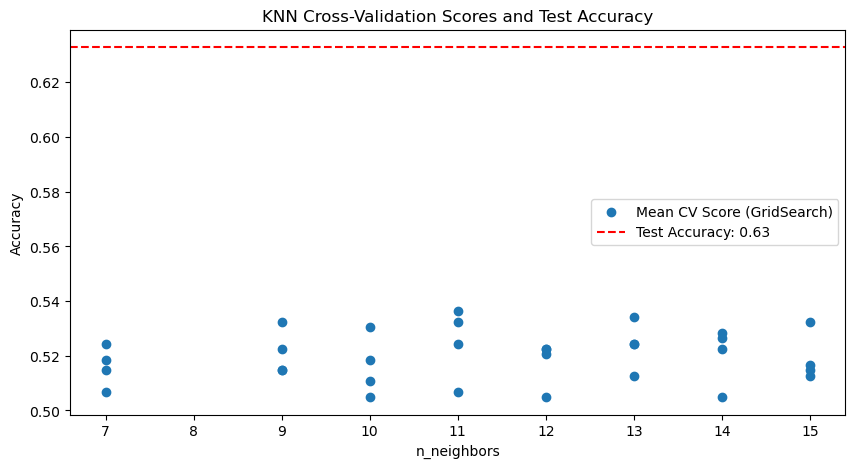

In [91]:
# Plotting cross-validation scores and test accuracy for best_knn
# Cross-validation scores from grid_search
cv_results = grid_search.cv_results_['mean_test_score']
param_n_neighbors = grid_search.cv_results_['param_n_neighbors']

plt.figure(figsize=(10, 5))
plt.scatter(param_n_neighbors, cv_results[:len(param_n_neighbors)], marker='o', label='Mean CV Score (GridSearch)')

# Test accuracy for best_knn
test_accuracy = best_knn.score(X_test, y_test)
plt.axhline(test_accuracy, color='red', linestyle='--', label=f'Test Accuracy: {test_accuracy:.2f}')

plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Cross-Validation Scores and Test Accuracy')
plt.legend()
plt.show()